In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from collections import deque
from datetime import datetime
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

drive_path = f'drive/MyDrive/Colab Notebooks/crypto_prediction/model3/'

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# ratios = ["BTCUSDT", "ETHUSDT", "NANOUSDT"]
ratios = ["BTCUSDT", "LTCUSDT", "ETHUSDT", "BNBUSDT",
          "ADAUSDT", "BTTUSDT", "DASHUSDT", "XMRUSDT",
          "NANOUSDT", "DOGEUSDT", "XLMUSDT", "BCHUSDT"]
RATIO_TO_PREDICT = "BTCUSDT"

NUM_FOLDS = 5  # for 10 we got val (input[test] of 10-fold) acc ~0.70 and test acc ~0.52. Overfiting to "val" set. Use 5, so its like 20% used for val
SEQ_LEN = 48
FUTURE_PERIOD_PREDICT = 1
EPOCHS = 40 # 12 # 40
BATCH_SIZE = 64
current_time = datetime.utcnow().strftime('%Y-%m-%d %H-%M-%S')
NAME = f"LSTM-{current_time}"

acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)

def construct_main_df(ratios):
    main_df = pd.DataFrame()
    # 'unix,date,symbol,open,high,low,close,Volume LTC,Volume USDT,tradecount'
    for ratio in ratios:
        dataset = f"{drive_path}data/Binance_{ratio}_1h.csv"
        df = pd.read_csv(dataset, nrows=None, skiprows=None, parse_dates=['date'], usecols=[0, 1, 2])  # todo
        df.set_index("date", inplace=True)

        if len(main_df) == 0:
            main_df = df
        else:
            main_df = main_df.join(df)

    # in this case it reduces main_df length to the length of pair with the smallest data
    main_df.dropna(how='any', inplace=True)

    # we determine targets by making ['future'] column with shifted rows,
    # and then if its price is higher than current day setting ['target'] to 1, and 0 otherwise
    main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)
    main_df['target'] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))
    main_df.drop('future', 1, inplace=True)  # future column is no longer needed, used only to determine target column
    # rows with future = NaN also are dropped here
    return main_df

def classify(current, future):
    return 1 if float(future) > float(current) else 0


# in k-fold we dont need validation set
def split_main_df(main_df, train_split, test_split):
    # [train train train train_index val val val val_index test test test_index]
    train_index = int(train_split * len(main_df))  # last indexes
    test_index = test_split  # we don't really need to use it, its always the last index

    train_df = main_df.iloc[:train_index]
    test_df = main_df.iloc[train_index:]
    return train_df, test_df

# percentage change and scaling
def preprocess_data(df):
    df = df.copy()  # fixes random SettingWithCopyWarning appearing with pct_change and preprocessing.scale
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()  # converted to percentage change
            # example:
            # hour 1:00 close = 93.13, hour 2:00 close = 92.41, so
            # 93.13 + 93.13 * x = 92.41, x = -0.007731
            # so percentage change of 1.0 means doubling the price
            # first row (the oldest values) is being filled with NaN percentage, but we don't want to drop whole row yet
            # so we wait until loop ends (we will have whole row filled with nans)
    df.dropna(inplace=True)
    # print('b', df.shape, df.isnull().values.any())
    for col in df.columns:
        if col != "target":
            # scaling should be used after splitting to training and test set - leaks data from test set to training
            df[col] = preprocessing.scale(df[col].values)  # normalizes to [-1, +1]
            # df[col] = preprocessing.StandardScaler().fit_transform(df[col].values.reshape(-1, 1)) # it does the same
            # scales the data so it has mean = 0, standard deviation = 1, variance = 1
            # it can be checked before and after with e.g. print(df['BTCUSDT_close'].mean())  .std()  .var()

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)  # list of SEQ_LEN items, we append to it, as it exceed, it pops old values

    for i in df.values:
        prev_days.append([n for n in i[:-1]])  # set of price and volume features added (-1 so without target)
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])
    # print(len(sequential_data))
    # ok so the sequences are like this ([a, b, 1] is single prev_days) (* and ^ just to point where it goes):
    # [([[a, b] [c, d], [e, f]], 1*)   ([[c, d] [e, f] [g, h]], 1) ... ([[g, h], [i, j], [k, l]], 0^)]
    random.shuffle(sequential_data)


    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys + sells  # concatenate lists
    random.shuffle(
        sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    x = []
    y = []

    for seq, target in sequential_data:
        x.append(seq)
        y.append(target)
    return np.array(x), np.array(y)

In [ ]:
time0 = time.perf_counter()
main_df = construct_main_df(ratios)
print(main_df.shape)
time1 = time.perf_counter()
# print(time1 - time0)

train_df, test_df = split_main_df(main_df, train_split=0.8, test_split=0.2)
print(train_df.shape, test_df.shape)
time2 = time.perf_counter()
# print(time2 - time1)

train_x, train_y = preprocess_data(train_df)
test_x, test_y = preprocess_data(test_df)
time3 = time.perf_counter()
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape,)
# print(time3 - time2)

(15737, 25)
(12589, 25) (3148, 25)
(12440, 48, 24) (12440,) (3066, 48, 24) (3066,)


In [ ]:
def build_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    # i cannot save CuDNNLSTM due to some error, not using it
    # model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(LSTM(128, input_shape=(train_x.shape[1:])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation="softmax"))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
    # opt = tf.keras.optimizers.Adam()

    model.compile(loss = "sparse_categorical_crossentropy", 
                  optimizer=opt,
                  metrics=['accuracy'])
    # print(model.summary())
    return model


In [ ]:
print(train_x.shape)


FINAL_PRODUCTION_TRAINING = True  # set manually!

if FINAL_PRODUCTION_TRAINING is False:
  # this way we can use test_x and test_y as final evaluation after k-fold
  inputs = train_x
  targets = train_y
elif FINAL_PRODUCTION_TRAINING is True:
  # this way we cant make that final evaluation, and rely on average score from k-fold
  inputs = np.concatenate((train_x, test_x), axis=0)
  targets = np.concatenate((train_y, test_y), axis=0)

# production model training should be performed with train_x with 100% of main_df. we can expect its results close to average score from k-fold evals
fold_no = 1
for train, test in kfold.split(inputs, targets):
    model = build_model()

    checkpoint = ModelCheckpoint(filepath=f"models/{NAME}", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # saves only the best ones
    earlystopping = EarlyStopping(monitor='accuracy', patience=4)  # todo val_loss not available for EarlyStopping callback
    cb = [earlystopping]
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(
            inputs[train], targets[train],
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=0,
            # validation_data=(validation_x, validation_y),
            callbacks=cb)
    
    scores = model.evaluate(inputs[test], targets[test], verbose=0)  # input[test] is like validation set, its part of training set
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1




(12440, 48, 24)
------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.3445900678634644; accuracy of 63.7653112411499%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.2719135284423828; accuracy of 64.75330591201782%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1.3596887588500977; accuracy of 65.07578492164612%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 1.2974392175674438; accuracy of 62.59270906448364%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.2682578563690186; accuracy of 65.68848490715027%


In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.3445900678634644 - Accuracy: 63.7653112411499%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2719135284423828 - Accuracy: 64.75330591201782%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.3596887588500977 - Accuracy: 65.07578492164612%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.2974392175674438 - Accuracy: 62.59270906448364%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2682578563690186 - Accuracy: 65.68848490715027%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 64.37511920928955 (+- 1.0869902263795579)
> Loss: 1.3083778858184814
-----------------------------

Trained model:
        loss  accuracy
39  0.124177  0.950181 



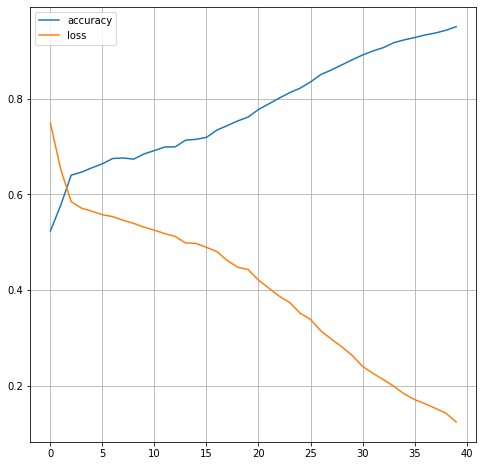

In [ ]:
def plot_history(history):
        hist_df = pd.DataFrame(history.history)
        print(f'Trained model:')
        print(hist_df.tail(1), '\n')
        hist_df_short = hist_df[['accuracy', 'loss']]
        hist_df_short.plot(figsize=(8,8), grid=True)

plot_history(history)

In [ ]:
model_path = f'{drive_path}models/{NAME}'
model.save(model_path)

model = keras.models.load_model(model_path)
score = model.evaluate(test_x, test_y, verbose=10)  # evaluate against unseen test data
print("TEST LOSS:", score[0])
print("TEST ACCURACY:", score[1])

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/crypto_prediction/model3/models/LSTM-2021-08-23 20-19-28/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/crypto_prediction/model3/models/LSTM-2021-08-23 20-19-28/assets


TEST LOSS: 0.3757164478302002
TEST ACCURACY: 0.8891063332557678


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)  # path to the SavedModel directory
tflite_model = converter.convert()

In [ ]:
with open(f'{model_path}.tflite', 'wb') as f:
    f.write(tflite_model)
    print("Finished")
    f.close()

Finished
